# speedtest.ipynb

This notebook analyzes Ookla speedtest data saved in a log file which is built
by automatically by a cron job which runs once every five minutes.

The code runs on an Ubuntu machine on which the Ookla speedtest command line interface has been installed.
`sudo apt install speedtest-cli`.

### Cron Job Configuration (see detailed explanation below)
```
*/5 * * * *  { printf "\%s" "$(date "+\%F \%T")"; speedtest; } >> /home/aubrey/Desktop/speedtest-$(date "+\%F").log 2>&1
```

### Log File
Every time the cron job runs, a speedtest is executed and results are written to the log file.
Here are the results for a single test stored in `/home/aubrey/Desktop/speedtest/speedtest-2025-03-07.log`.
```
2025-03-07 14:50:01
   Speedtest by Ookla

      Server: Fil Products Negros - Dumaguete City (id: 32015)
         ISP: FIl Products Service Television Inc
Idle Latency:     3.95 ms   (jitter: 1.02ms, low: 3.23ms, high: 5.28ms)
    Download:    86.89 Mbps (data used: 122.3 MB)                                                   
                137.24 ms   (jitter: 45.36ms, low: 2.38ms, high: 280.98ms)
      Upload:    88.34 Mbps (data used: 69.5 MB)                                                   
                 15.20 ms   (jitter: 8.43ms, low: 6.10ms, high: 242.90ms)
 Packet Loss:     0.0%
  Result URL: https://www.speedtest.net/result/c/dfc28f48-d4b7-4ff3-ba04-19b98f75b882
```

## An Explanation of the Crontab Configuration

Below is the relevant line from the crontab configuration file. This file can be edited using `crontab -e`. Note that
the cron job can be disabled ('commented out') by adding `#` as the first character.
```
*/5 * * * *  { printf "\%s" "$(date "+\%F \%T")"; speedtest; } >> /home/aubrey/Desktop/speedtest-$(date "+\%F").log 2>&1
```

### Crontab Schedule
```
*/5 * * * *
```
This part specifies the schedule for the cron job. It means the command will run every 5 minutes. Here's the breakdown:
- `*/5`: Every 5 minutes
- `*`: Every hour
- `*`: Every day of the month
- `*`: Every month
- `*`: Every day of the week

### Command to Execute
```
{ printf "\%s," "$(date "+\%F \%T")"; speedtest; }
```
This part is the command that will be executed every 5 minutes. Let's break it down further:
- `{ ... }`: Groups the commands together.
- `printf "\%s" "$(date "+\%F \%T")"`: Prints the current date and time in the format `YYYY-MM-DD HH:MM:SS`, followed by a comma.
- `speedtest`: Runs the `speedtest` command, which is typically used to check internet speed.

### Output Redirection
```
>> /home/aubrey/Desktop/speedtest-$(date "+\%F").log 2>&1
```
This part handles where the output of the command will go:
- `>>`: Appends the output to the specified file.
- `/home/aubrey/Desktop/speedtest-$(date "+\%F").log`: The file path where the output will be saved. The `$(date "+\%F")` part dynamically includes the current date in the filename, so a new log file is created each day.
- `2>&1`: Redirects standard error (file descriptor 2) to standard output (file descriptor 1), so both standard output and standard error are appended to the log file.

### Summary
Every 5 minutes, this cron job will:
1. Print the current date and time.
2. Run the `speedtest` command.
3. Append the output (including any errors) to a log file named with the current date.

This setup helps in monitoring internet speed at regular intervals and logs the results for later analysis.

In [72]:
import re
from icecream import ic
import pandas as pd
import matplotlib.pyplot as plt

In [73]:
LOG_PATH = '/home/aubrey/Desktop/speedtest-2025-03-07.log'

In [74]:
# Read the log
with open(LOG_PATH) as f:
    lines = f.readlines()

In [75]:
# Parse the log data, extracting timestamp, download_Mbps, and upload_Mbps using regular expressions.
# Result is saved as a list of dicts which can be imported by pandas.
mylist = []
mydict = {}

for line in lines:
    
    timestamp = re.search(r"([0-9]{4}-[0-9]{2}-[0-9]{2}\s+[0-9]{2}:[0-9]{2}:[0-9]{2})", line)
    if timestamp:  
        if len(mydict) > 0:       
            mylist.append(mydict)
        mydict = {'timestamp': timestamp.group(1), 'download_Mbps': 0, 'upload_Mbps': 0}
        # s += f'{timestamp.group(1)},'
        
    download_Mbps = re.search(r"Download:\s+([0-9]+\.[0-9]+)\s+Mbps", line)
    if download_Mbps:
        mydict['download_Mbps'] = download_Mbps.group(1)
        # s += f'{download_Mbps.group(1)},'
               
    upload_Mbps = re.search(r"Upload:\s+([0-9]+\.[0-9]+)\s+Mbps", line)
    if upload_Mbps:
        mydict['upload_Mbps'] = upload_Mbps.group(1)
        # s += f'{upload_Mbps.group(1)}\n'
        
mylist.append(mydict)

In [76]:
# Import data into a pandas dataframe
df = pd.DataFrame(mylist)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['HM'] = df['timestamp'].dt.strftime('%H:%M')
df['download_Mbps'] = df['download_Mbps'].astype(float)
df['upload_Mbps'] = df['upload_Mbps'].astype(float)
df

,timestamp,download_Mbps,upload_Mbps,HM
0,2025-03-07 00:00:01,53.37,76.90,00:00
1,2025-03-07 00:05:01,92.47,93.35,00:05
2,2025-03-07 00:10:01,94.35,93.61,00:10
3,2025-03-07 00:15:01,92.57,91.23,00:15
4,2025-03-07 00:20:01,91.78,93.67,00:20
...,...,...,...,...
291,2025-03-07 23:35:01,91.68,93.60,23:35
292,2025-03-07 23:40:01,90.68,93.62,23:40
293,2025-03-07 23:45:01,89.65,93.42,23:45
294,2025-03-07 23:50:01,94.82,93.68,23:50


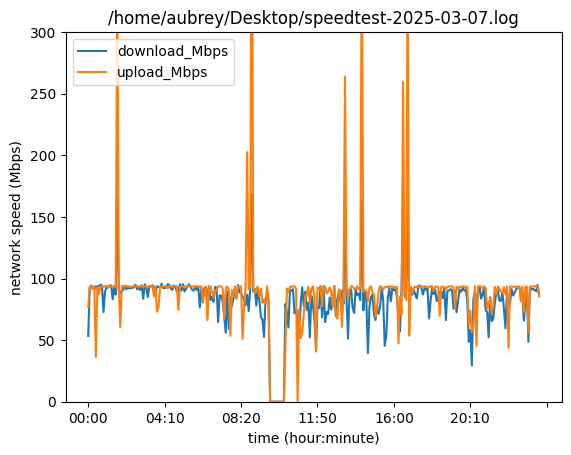

In [77]:
# Plot the data and save as PNG
df.plot(
    x='HM',
    y=['download_Mbps', 'upload_Mbps'],
    ylim=[0,300],
    title=LOG_PATH,
    xlabel='time (hour:minute)',
    ylabel='network speed (Mbps)'
);
plt.savefig(LOG_PATH.replace('.log', '.png'))